## Introduction to the automated analysis of EEG quality

This notebook will introduce you to the challenge by going through the data and working towards a first very simple model.

## Loading the data

In [4]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd

ROOT_PATH = Path("train/")
training_data = [(np.load(ROOT_PATH / f"data_{i}.npy"),np.load(ROOT_PATH / f"target_{i}.npy")) for i in range(4)]


We expect to have five channels and one label per channel for each two seconds of data.
Let's have a look at the data duration and shape

In [5]:
# Let's have a look at the data duration
for i,(data,target) in enumerate(training_data):
    print()
    print(f"Recording {i}")
    print("Data shape", data.shape,target.shape)
    print("Data duration:", data.shape[1]/250)
    print("Labels duration",target.shape[1] * 2)
    



Recording 0
Data shape (5, 7712740) (5, 15425)
Data duration: 30850.96
Labels duration 30850

Recording 1
Data shape (5, 5232364) (5, 10464)
Data duration: 20929.456
Labels duration 20928

Recording 2
Data shape (5, 6421756) (5, 12843)
Data duration: 25687.024
Labels duration 25686

Recording 3
Data shape (5, 6809761) (5, 13619)
Data duration: 27239.044
Labels duration 27238


## Plotting the EEG and labels

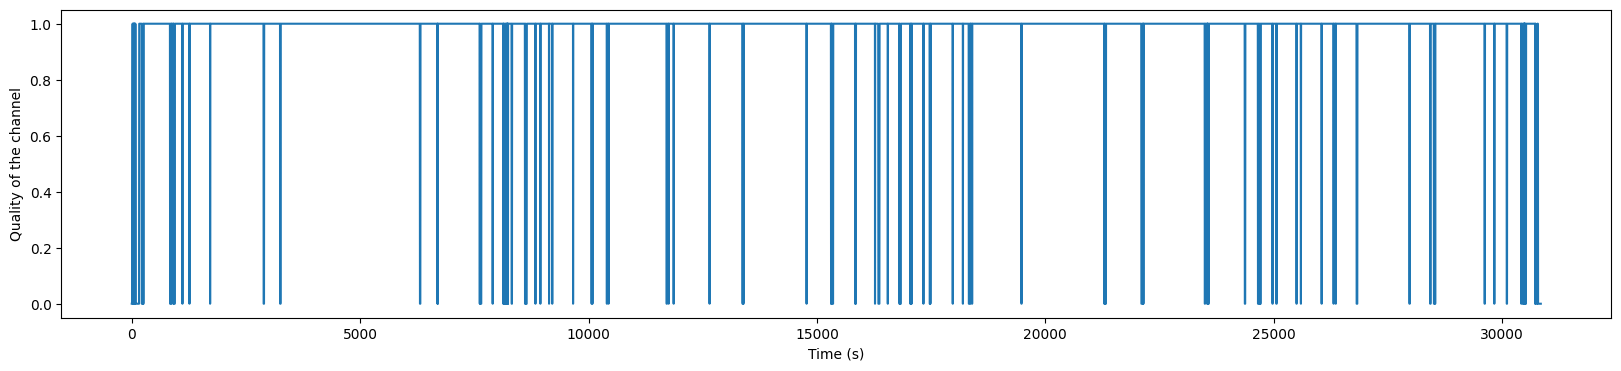

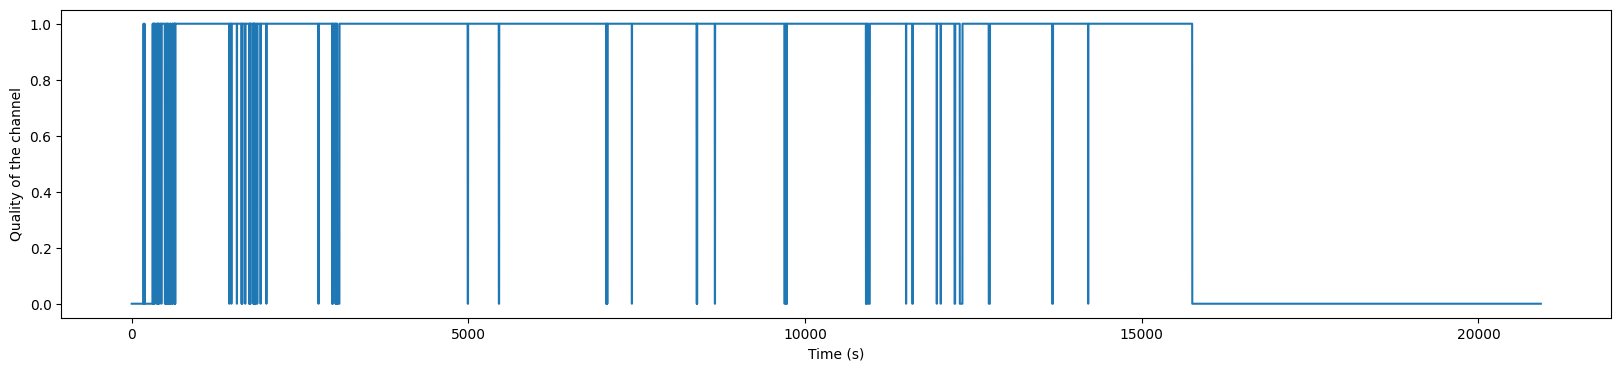

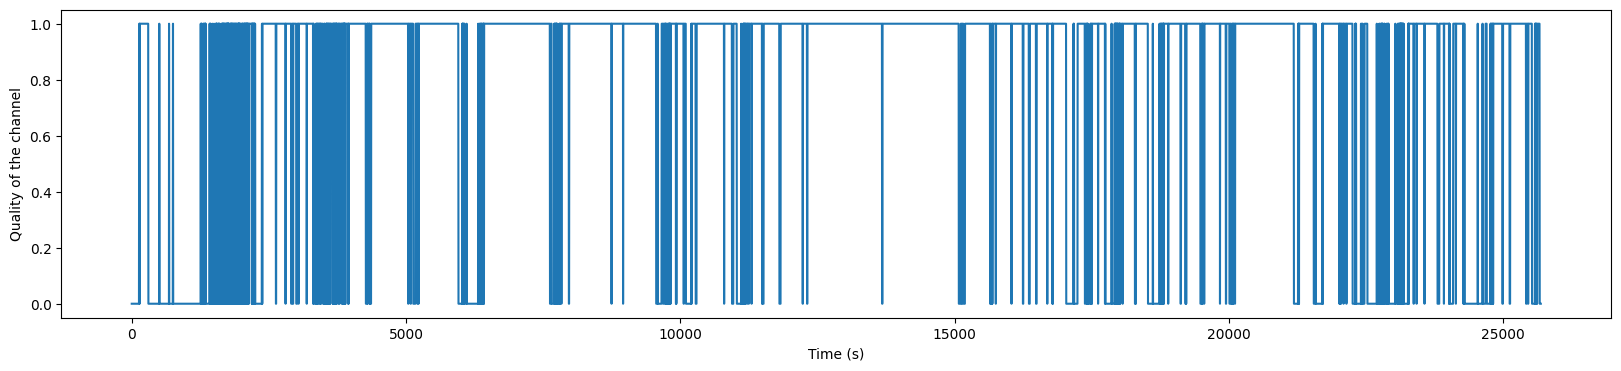

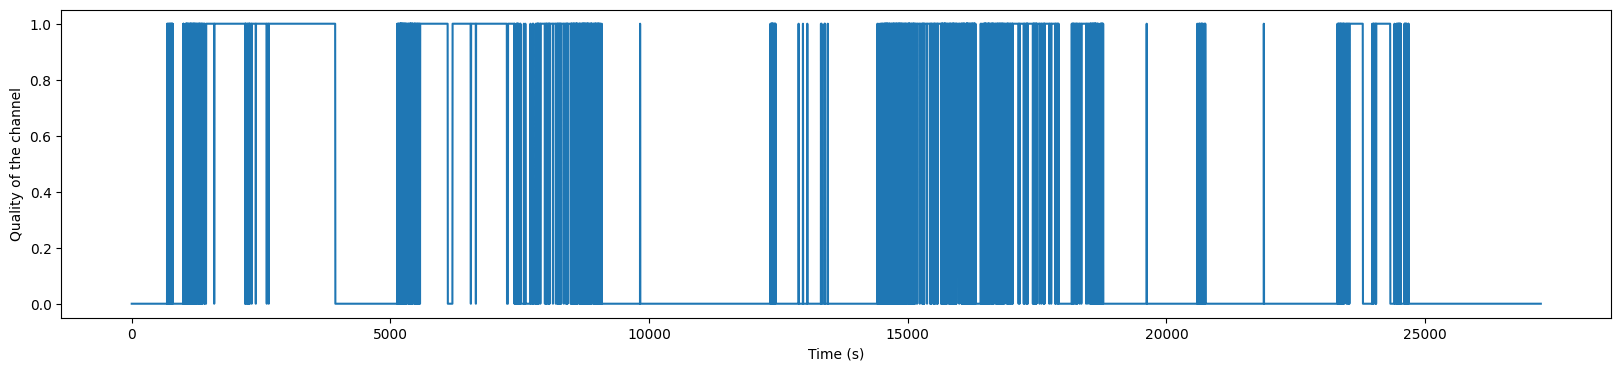

In [6]:

# Let's plot the target from the first channel for all the recordings
for i,(data,target) in enumerate(training_data):
    plt.figure(figsize=(20,4))
    plt.plot(np.arange(0,len(target[0])) * 2, target[0])
    plt.ylabel('Quality of the channel')
    plt.xlabel("Time (s)")
    plt.show()

In [7]:
## We improve a bit the plotting code to plot span of data and corresponding label

def plot_predictions_and_signal(
    target,
    data,
    start_time: float,
    stop_time: float,
    data_sampling_rate: int = 250,
    target_duration: int = 2,
    channel_to_plot: int = 0,
):
    """
    
    
    """

    # Calculate the start and stop indices for the signal
    start_idx_signal = int(start_time * data_sampling_rate)
    stop_idx_signal = int(stop_time * data_sampling_rate)

    # Calculate the start and stop indices for the labels
    start_idx_label = int(start_time / target_duration)
    stop_idx_label = int(stop_time / target_duration)

    # Slice the data and prediction probabilities
    sliced_signal = data[channel_to_plot, start_idx_signal:stop_idx_signal]
    sliced_prediction_prob = (
        target[channel_to_plot, start_idx_label:stop_idx_label]
    )

    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    # Plot the sliced EEG signal
    ax[0].plot(np.arange(len(sliced_signal)) / data_sampling_rate, sliced_signal)
    ax[0].set_title("EEG signal")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")

    ax[1].plot(
        np.arange(len(sliced_prediction_prob)) * target_duration,
        sliced_prediction_prob,
    )
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Probs")

    plt.show()



0.5086964831804281


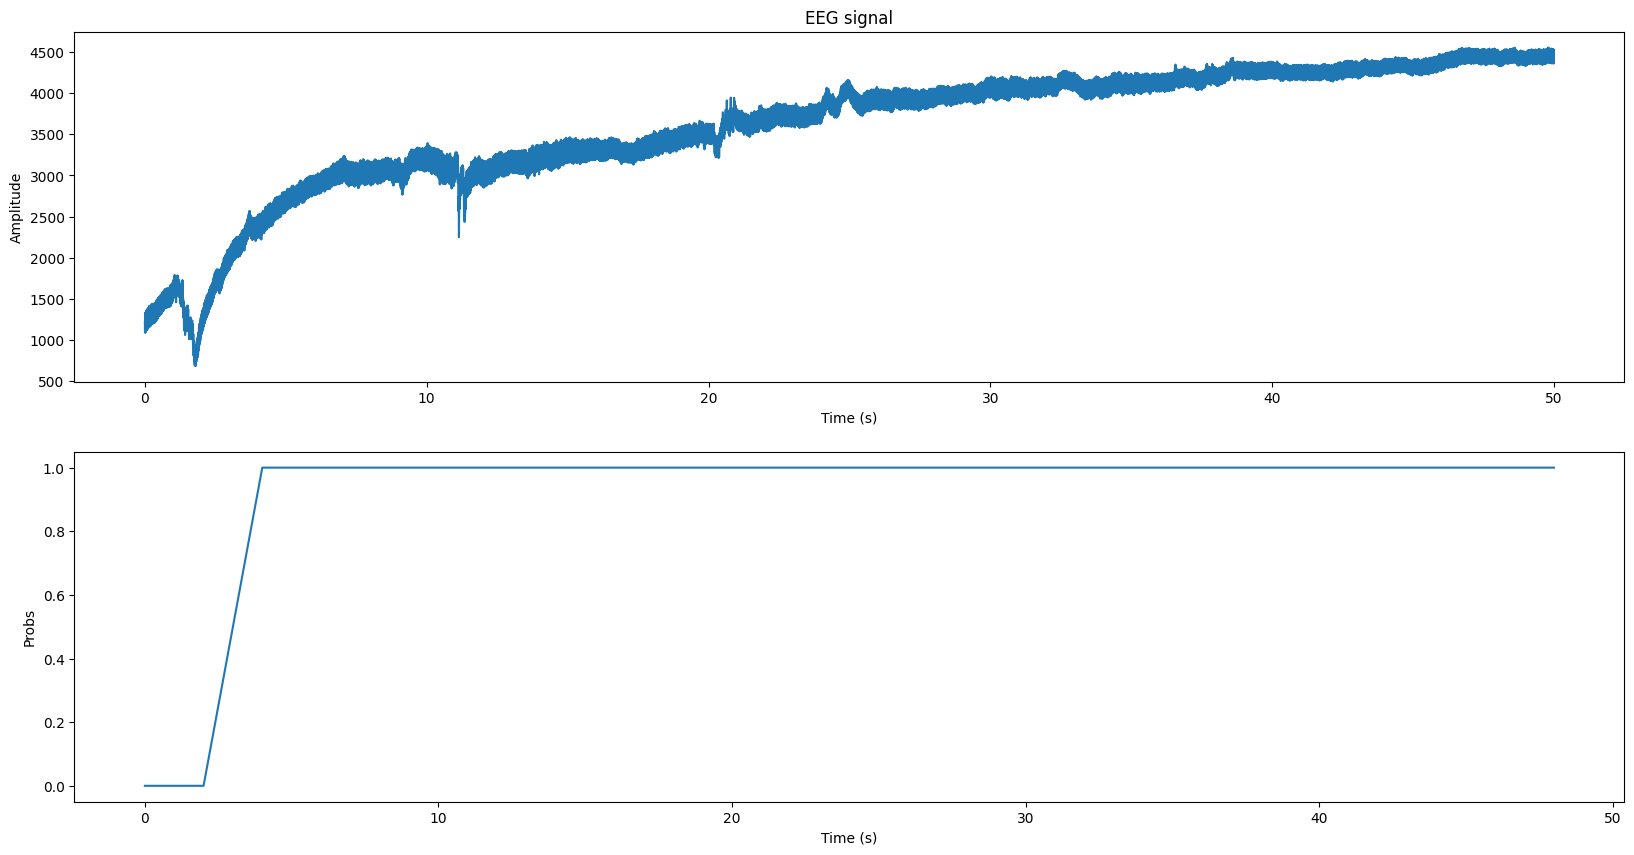

In [8]:
# We first plot the data and target from the first recording
# We see that there is a big DC component 
target = np.load("train/target_1.npy")
data = np.load("train/data_1.npy")
print(np.mean(target))
plot_predictions_and_signal(target,data,start_time = 300, stop_time = 350, data_sampling_rate = 250,target_duration = 2, channel_to_plot = 2)

To remove the DC component and high frequency component we apply a band-pass filter

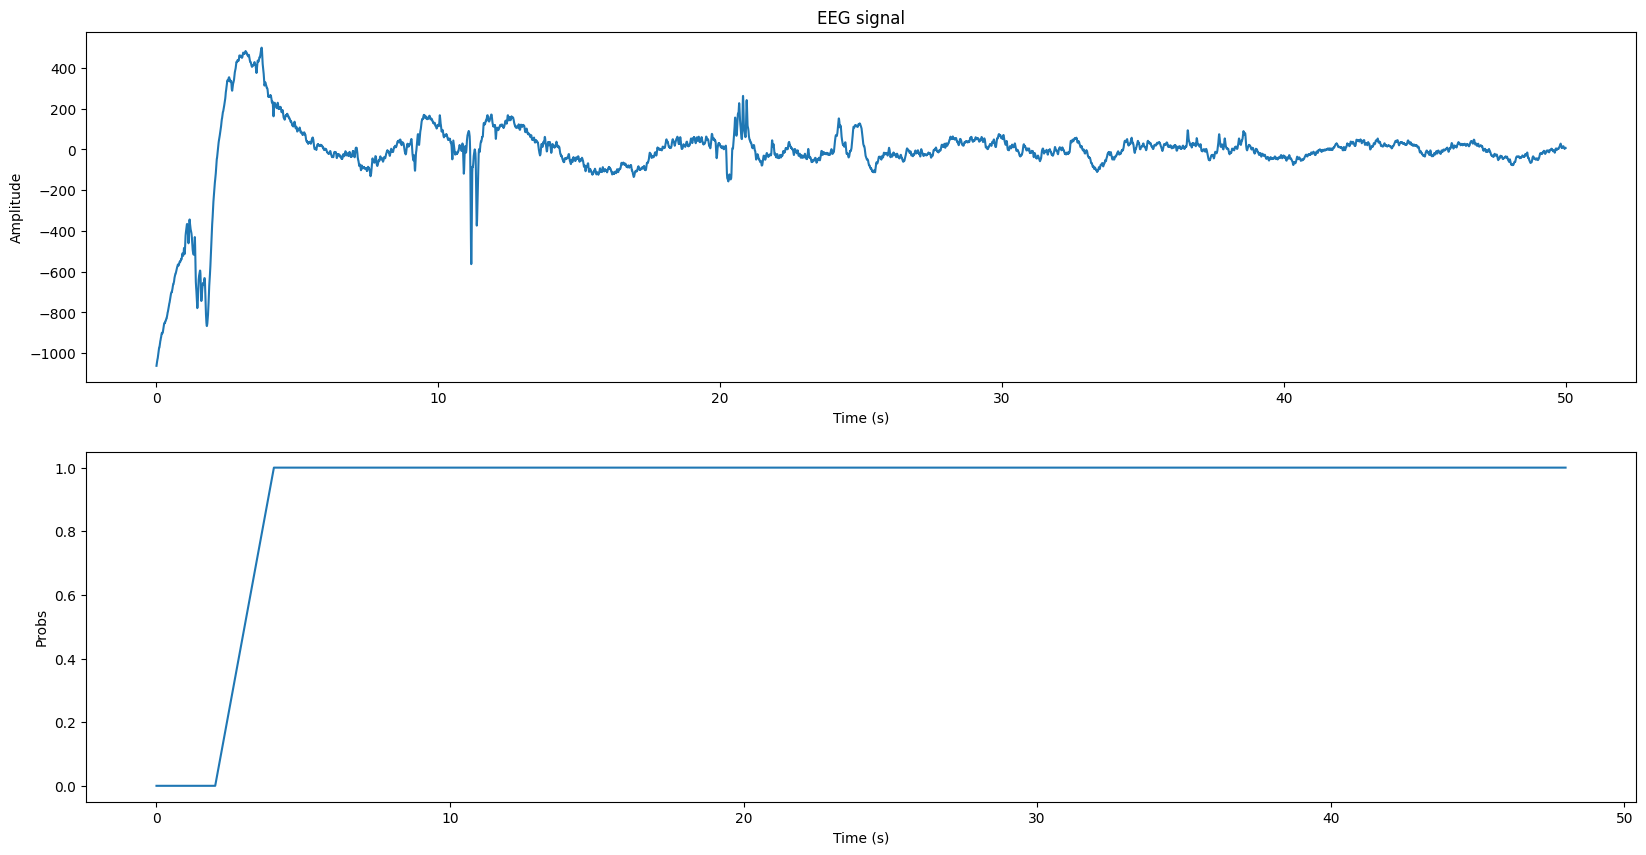

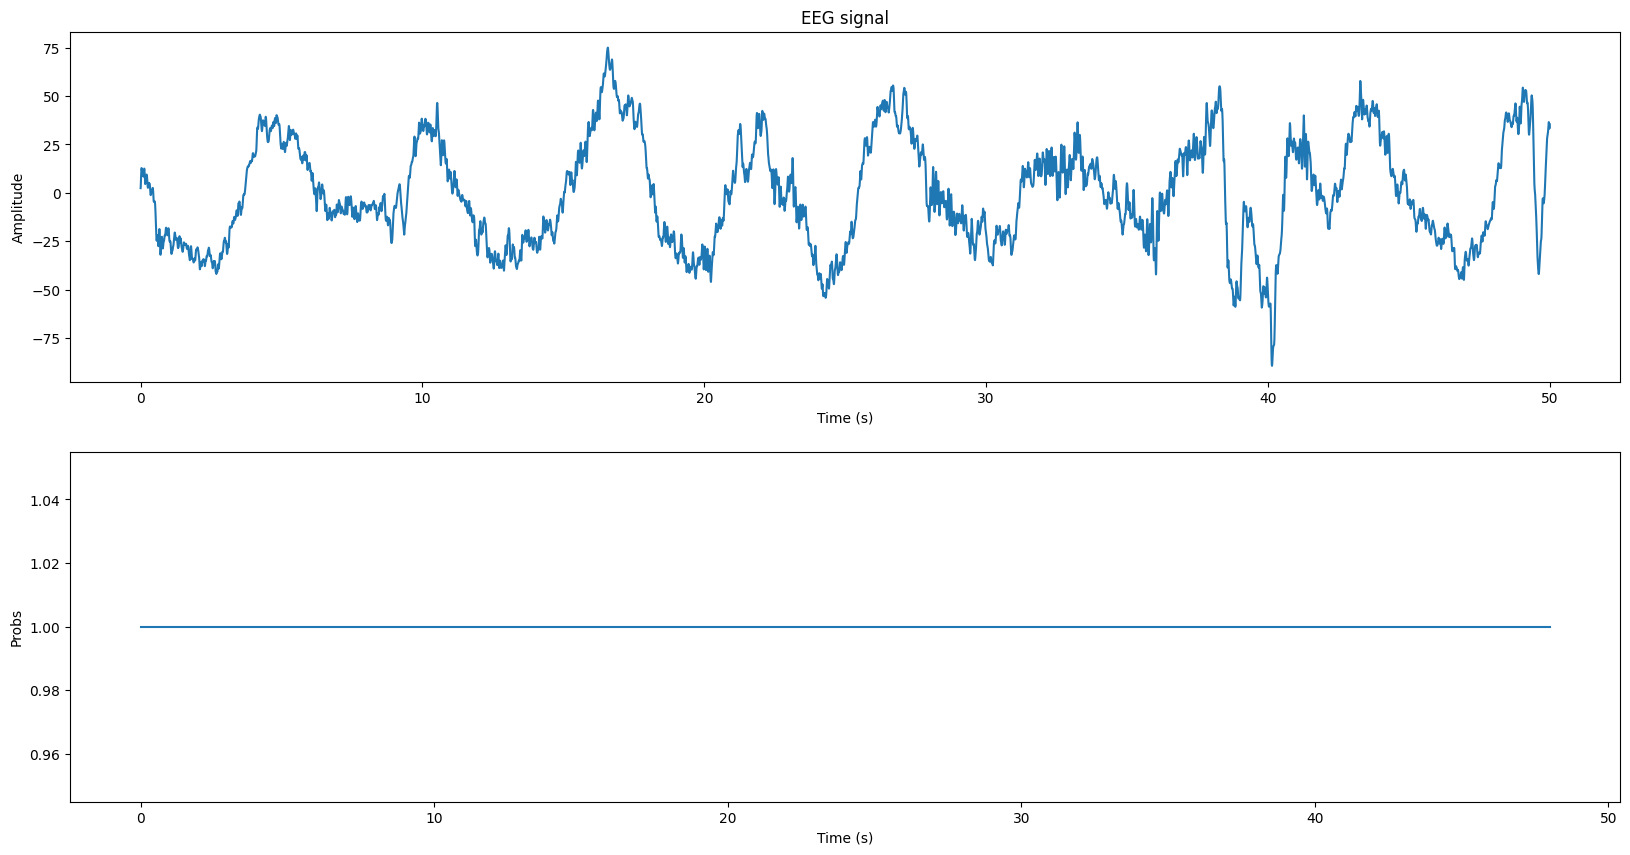

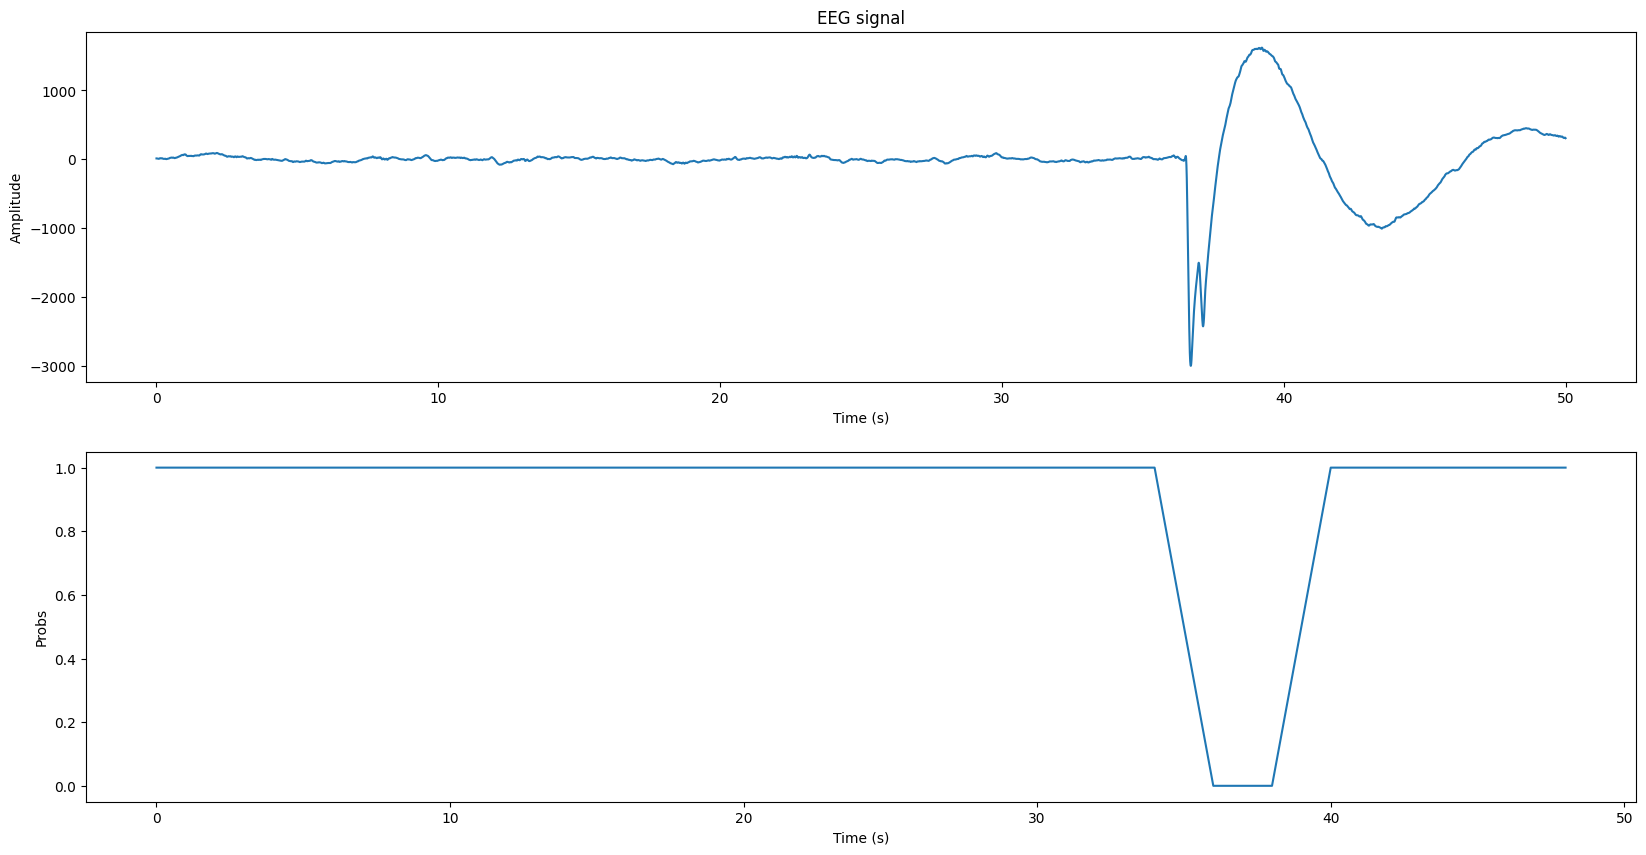

In [9]:
# Let's filter the signal to improve the visualisation

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

filtered_data = butter_bandpass_filter(data,0.1,18,250,4)
# We plot three spans and associated labels from the recording

plot_predictions_and_signal(target,filtered_data,start_time = 300, stop_time = 350, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)
plot_predictions_and_signal(target,filtered_data,start_time = 1000, stop_time = 1050, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)
plot_predictions_and_signal(target,filtered_data,start_time = 3000, stop_time = 3050, data_sampling_rate = 250,target_duration = 2 ,channel_to_plot = 2)

We see that some of the high amplitude is classified as bad quality, we could use that to build a first simple model

## Exploring the statistics of the good and bad quality EEG

In [10]:
# First we need to get the point that maps to a label

def reshape_array_into_windows(x, sample_rate, window_duration_in_seconds):
    """
    Reshape the data into an array of shape (C, T, window) where 'window' contains
    the points corresponding to 'window_duration' seconds of data.

    Parameters:
    x (numpy array): The input data array.
    sample_rate (int): The number of samples per second.
    window_duration_in_seconds (float): The duration of each window in seconds.

    Returns:
    reshaped_x (numpy array): The reshaped array with shape (C, T, window).
    """
    # Calculate the number of samples in one window
    window_size = int(window_duration_in_seconds * sample_rate)
    
    # Ensure the total length of x is a multiple of window_size
    total_samples = x.shape[-1]
    if total_samples % window_size != 0:
        # Truncate or pad x to make it divisible by window_size
        x = x[..., :total_samples - (total_samples % window_size)]
    # Reshape x into (C, T, window)
    reshaped_x = x.reshape(x.shape[0], -1, window_size)

    return reshaped_x


In [11]:
reshaped_array = reshape_array_into_windows(filtered_data,250,2)
# Quick unit test to ensure the reshape worked as expected
assert np.array_equal(reshaped_array[0,0],filtered_data[0,:500])
assert np.array_equal(reshaped_array[0,1],filtered_data[0,500:1000])
assert np.array_equal(reshaped_array[0,10],filtered_data[0,5000:5500])
assert np.array_equal(reshaped_array[1,1],filtered_data[1,500:1000])




In [12]:
reshaped_array.shape

(5, 10464, 500)

In [13]:
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude = (np.max(reshaped_array,-1) - np.min(reshaped_array,-1)).reshape(-1)
targets_flatten = target[..., :len(reshaped_array[0])].reshape(-1)

In [14]:
data = pd.DataFrame({"amplitude":amplitude,"target":targets_flatten})

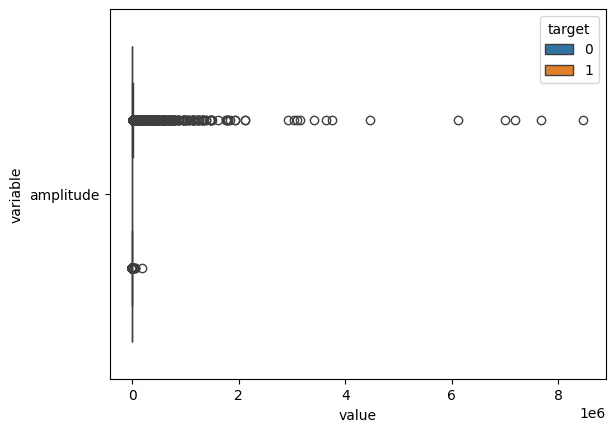

In [15]:
melted_data = pd.melt(data, value_vars = ["amplitude"],id_vars = "target")
sns.boxplot(melted_data,y = "variable", x = "value",hue = "target")
plt.show()

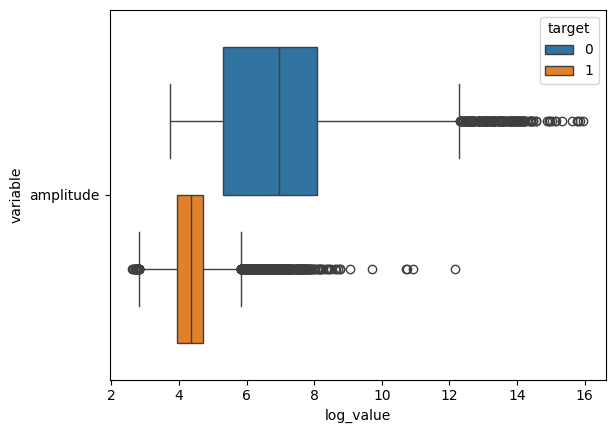

In [16]:
# We need to take the log to visualize the data better
# The goof (target = 1) and bad (target = 0) data seems to be relatively separable based on our three features
melted_data["log_value"] = np.abs(np.log(melted_data.value + 1))
sns.boxplot(melted_data,y = "variable", x = "log_value",hue = "target")
plt.show()

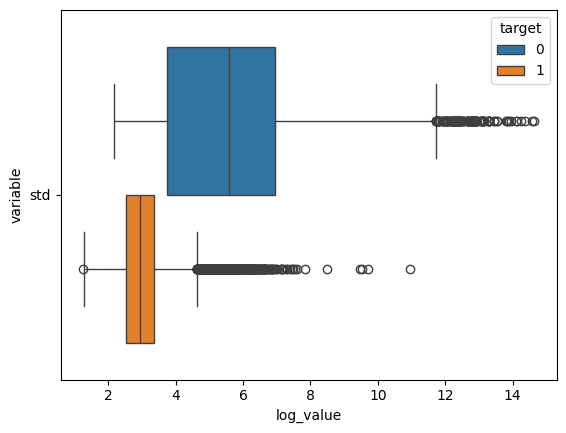

In [17]:
# Compute standard deviation
std = np.std(reshaped_array,-1).reshape(-1)
data = pd.DataFrame({"std":std,"target":targets_flatten})
melted_data = pd.melt(data, value_vars = ["std"],id_vars = "target")
melted_data["log_value"] = np.abs(np.log(melted_data.value + 1))
sns.boxplot(melted_data,y = "variable", x = "log_value",hue = "target")
plt.show()

In [18]:
# Explore FFT features

def compute_fft(data,sample_rate):
    """
    Compute the FFT of the data
    
    Parameters:
    data (numpy array): The input data array.
    sample_rate (int): The number of samples per second.
    
    Returns:
    fft_values (numpy array): The FFT values
    """
    # Compute the FFT
    fft_values = np.fft.rfft(data)
    
    # Compute the frequencies corresponding to the FFT values
    frequencies = np.fft.rfftfreq(data.size, d=1/sample_rate)
    
    return fft_values, frequencies

In [19]:
# Compute the FFT features for all the channels
fft_values = []
frequencies = []
for i in range(reshaped_array.shape[1]):
    fft_values.append([])
    frequencies.append([])
    for ch in range(reshaped_array.shape[0]):
        fft_val, freq = compute_fft(reshaped_array[ch,i],250)
        fft_values[i].append(fft_val)
        frequencies[i].append(freq)
    

In [20]:
fft_values = np.array(fft_values)
frequencies = np.array(frequencies)
print(fft_values.shape,frequencies.shape)

(10464, 5, 251) (10464, 5, 251)


In [21]:
# Select the 2 most important frequencies for each channel and each window
top_freq = np.argmax(np.abs(fft_values), axis=2)
top_freq_values = np.max(np.abs(fft_values), axis=2)
print(top_freq.shape,top_freq_values.shape)

(10464, 5) (10464, 5)


In [22]:
top_freq = top_freq.reshape(-1)
print(top_freq.shape)

(52320,)


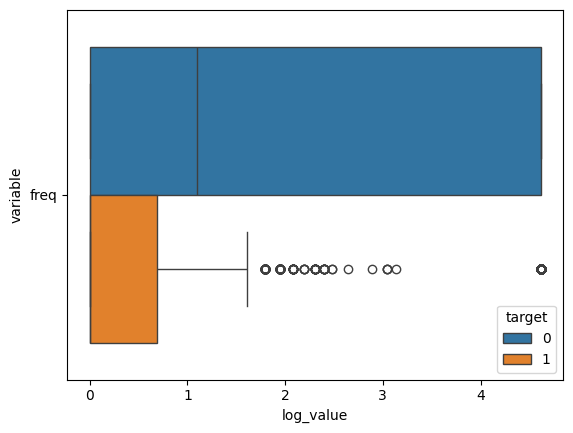

In [23]:
# Box plot of the top 2 frequencies
data = pd.DataFrame({"freq": top_freq,"target":targets_flatten})
melted_data = pd.melt(data, value_vars = ["freq"],id_vars = "target")

# We need to take the log to visualize the data better
melted_data["log_value"] = np.abs(np.log(melted_data.value + 1))
sns.boxplot(melted_data,y = "variable", x = "log_value",hue = "target")
plt.show()



In [24]:
# Looking for usually present frequencies in EEG

alpha = (8,13)
beta = (13,30)
theta = (4,8)
delta = (0.5,4)

alpha_mask = (frequencies > alpha[0]) & (frequencies < alpha[1])
beta_mask = (frequencies > beta[0]) & (frequencies < beta[1])
theta_mask = (frequencies > theta[0]) & (frequencies < theta[1])
delta_mask = (frequencies > delta[0]) & (frequencies < delta[1])

print(alpha_mask.shape)


(10464, 5, 251)


In [25]:
alpha_values = []
beta_values = []
theta_values = []
delta_values = []

for tw in range(fft_values.shape[0]):
    alpha_values.append([])
    beta_values.append([])
    theta_values.append([])
    delta_values.append([])
    for channel in range(fft_values.shape[1]):
        alpha_values[tw].append(np.mean(fft_values[tw,channel,alpha_mask[tw, channel]]))
        beta_values[tw].append(np.mean(fft_values[tw,channel,beta_mask[tw, channel]]))
        theta_values[tw].append(np.mean(fft_values[tw,channel,theta_mask[tw, channel]]))
        delta_values[tw].append(np.mean(fft_values[tw,channel,delta_mask[tw, channel]]))
    

In [26]:
alpha_values = np.array(alpha_values)
beta_values = np.array(beta_values)
theta_values = np.array(theta_values)
delta_values = np.array(delta_values)

print(alpha_values.shape,beta_values.shape,theta_values.shape,delta_values.shape)

(10464, 5) (10464, 5) (10464, 5) (10464, 5)


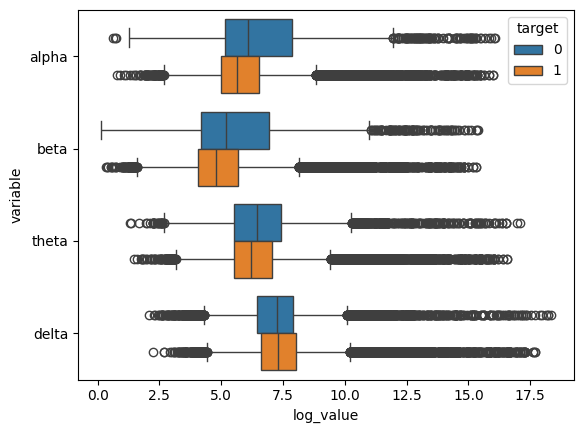

In [27]:
# Box plot of each frequency band
data = pd.DataFrame({"alpha": alpha_values.flatten(),"beta": beta_values.flatten(),"theta": theta_values.flatten(),"delta": delta_values.flatten(),"target":targets_flatten})

melted_data = pd.melt(data, value_vars = ["alpha","beta","theta","delta"],id_vars = "target")

# We need to take the log to visualize the data better
melted_data["log_value"] = np.abs(np.log(melted_data.value + 1))
sns.boxplot(melted_data,y = "variable", x = "log_value",hue = "target")
plt.show()


In [28]:
# Compute correlation between adjacent time windows

def compute_correlation(tw_1, tw_2):
    """
    Compute the correlation between two time windows.
    
    Parameters:
    tw_1 (numpy array): The first time window.
    tw_2 (numpy array): The second time window.
    
    Returns:
    correlation (float): The correlation between tw_1 and tw_2.
    """
    # Compute the correlation
    correlation = np.corrcoef(tw_1, tw_2)[0, 1]
    
    return correlation

In [29]:
# Compute the correlation between adjacent time windows for each channel
correlations = []
for ch in range(reshaped_array.shape[0]):
    correlations.append([compute_correlation(reshaped_array[ch, i], reshaped_array[ch, i + 1]) for i in range(reshaped_array.shape[1] - 1)])

correlations = np.array(correlations)
correlations.shape

(5, 10463)

In [30]:
# Add 0 at the beginning of each channel to have the same shape as reshaped_array
correlations = np.array([np.concatenate([[0], corr]) for corr in correlations])
correlations.shape

(5, 10464)

In [31]:
correlations = correlations.reshape(-1)

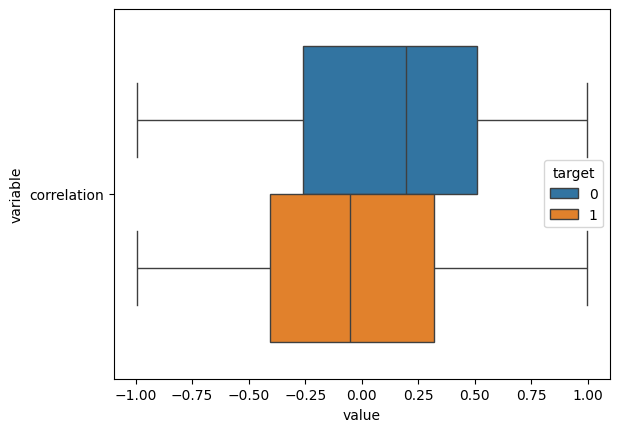

In [32]:
# Box plot of the correlation values
data = pd.DataFrame({"correlation": correlations,"target":targets_flatten[:]})

melted_data = pd.melt(data, value_vars = ["correlation"],id_vars = "target")

sns.boxplot(melted_data,y = "variable", x = "value",hue = "target")
plt.show()

C:\Users\Emile\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


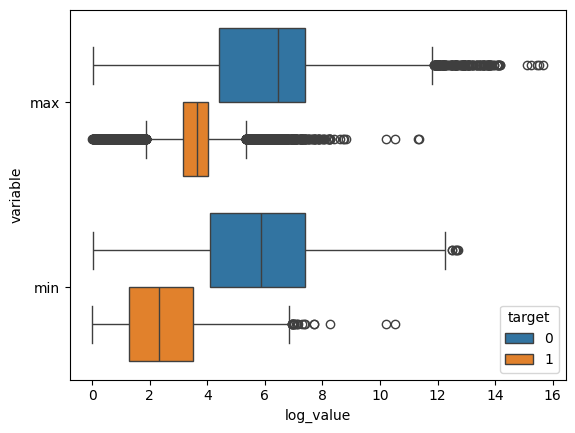

In [33]:
# Compute max and min values for each channel and each time window
max_values = np.max(reshaped_array, axis=2)
min_values = np.min(reshaped_array, axis=2)

max_values = max_values.reshape(-1)
min_values = min_values.reshape(-1)

# Box plot of the max and min values

data = pd.DataFrame({"max": max_values,"min": min_values,"target":targets_flatten[:]})

melted_data = pd.melt(data, value_vars = ["max","min"],id_vars = "target")
# We need to take the log to visualize the data better
melted_data["log_value"] = np.abs(np.log(melted_data.value + 1))
sns.boxplot(melted_data,y = "variable", x = "log_value",hue = "target")
plt.show()

In [34]:
from scipy.stats import entropy

def compute_entropy(data):
    """
    Compute the entropy of the data.
    
    Parameters:
    data (numpy array): The input data array.
    
    Returns:
    entropy_value (float): The entropy of the data.
    """
    # Compute the histogram of the data
    hist, _ = np.histogram(data, bins=100)
    
    # Compute the entropy
    entropy_value = entropy(hist)
    
    return entropy_value

# Compute the entropy for each channel and each time window

entropies = np.array([[compute_entropy(reshaped_array[ch, i]) for i in range(reshaped_array.shape[1])] for ch in range(reshaped_array.shape[0])])

entropies = entropies.reshape(-1)
print(entropies.shape)

(52320,)


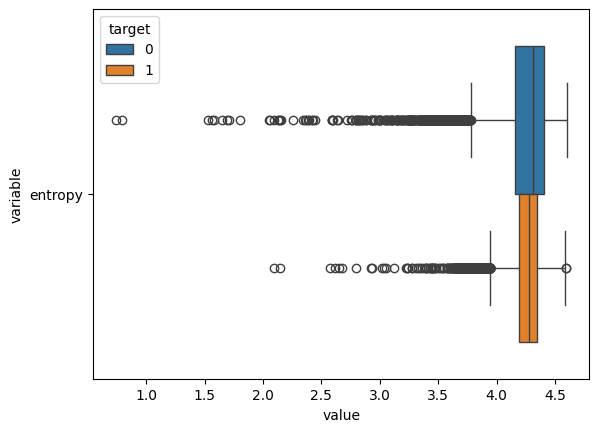

In [35]:
# Box plot of the entropy values
data = pd.DataFrame({"entropy": entropies,"target":targets_flatten[:]})

melted_data = pd.melt(data, value_vars = ["entropy"],id_vars = "target")

sns.boxplot(melted_data,y = "variable", x = "value",hue = "target")
plt.show()

In [36]:
# Compute cepstral coefficients

from scipy.fftpack import dct

def compute_cepstral_coefficients(data, num_coefficients=2):
    """
    Compute the cepstral coefficients of the data.
    
    Parameters:
    data (numpy array): The input data array.
    num_coefficients (int): The number of cepstral coefficients to compute.
    
    Returns:
    cepstral_coefficients (numpy array): The cepstral coefficients of the data.
    """
    # Compute the FFT of the data
    fft_values = np.fft.rfft(data)
    
    # Compute the power spectrum
    power_spectrum = np.abs(fft_values) ** 2
    
    # Compute the log of the power spectrum
    log_power_spectrum = np.log(power_spectrum + 1e-10)
    
    # Compute the cepstral coefficients
    cepstral_coefficients = dct(log_power_spectrum, type=2, axis=0, norm="ortho")[:num_coefficients]
    
    return cepstral_coefficients

In [37]:
# Compute the cepstral coefficients for each channel and each time window
cepstral_coefficients = np.array([[compute_cepstral_coefficients(reshaped_array[ch, i]) for i in range(reshaped_array.shape[1])] for ch in range(reshaped_array.shape[0])])

cepstral_coefficients = cepstral_coefficients.reshape(-1, 2)
print(cepstral_coefficients.shape)

(52320, 2)


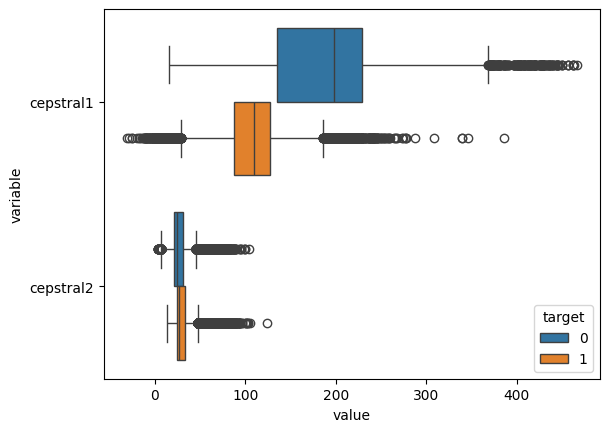

In [38]:
# Box plot of the cepstral coefficients
data = pd.DataFrame({"cepstral1": cepstral_coefficients[:, 0],"cepstral2": cepstral_coefficients[:, 1],"target":targets_flatten[:]})

melted_data = pd.melt(data, value_vars = ["cepstral1","cepstral2"],id_vars = "target")

sns.boxplot(melted_data,y = "variable", x = "value",hue = "target")
plt.show()

In [54]:
# Compute mutual information between channels

from sklearn.feature_selection import mutual_info_regression

def compute_mutual_information(tw_1, tw_2):
    """
    Compute the mutual information between two time windows.
    
    Parameters:
    tw_1 (numpy array): The first time window.
    tw_2 (numpy array): The second time window.
    
    Returns:
    mutual_information (float): The mutual information between tw_1 and tw_2.
    """
    # Compute the mutual information
    mutual_information = mutual_info_regression(tw_1.reshape(-1, 1), tw_2)
    
    return float(mutual_information[0])

# example

compute_mutual_information(reshaped_array[0,0],reshaped_array[0,1])

2.6578173198421124

In [ ]:
# Compute the mutual information between channels for each time window
mutual_informations = np.zeros((reshaped_array.shape[0], reshaped_array.shape[0], reshaped_array.shape[1]))
for i in range(reshaped_array.shape[1]):
    for ch1 in range(reshaped_array.shape[0]):
        for ch2 in range(reshaped_array.shape[0]):
            if ch1 < ch2:
                mutual_informations[ch1, ch2, i] = compute_mutual_information(reshaped_array[ch1, i], reshaped_array[ch2, i])
                mutual_informations[ch2, ch1, i] = mutual_informations[ch1, ch2, i]

In [148]:
print(mutual_informations.shape)

(5, 5, 10464)


In [154]:
# Build and array with the 4 mutual information values for each time window
mutual_informations_features = []
for ch in range(reshaped_array.shape[0]):
    mutual_informations_features.append([])
    for i in range(reshaped_array.shape[1]):
        mutual_informations_features[ch].append([mutual_informations[ch, ch2, i] for ch2 in range(reshaped_array.shape[0]) if ch != ch2])

In [ ]:
mutual_informations_features = np.array(mutual_informations_features)
print(mutual_informations_features.shape)

(5, 10464, 4)


In [158]:
mutual_informations_features = mutual_informations_features.reshape(-1, 4)

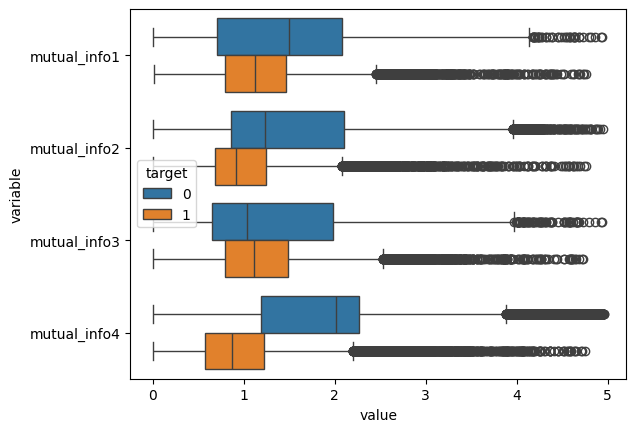

In [159]:
# Box plot of the mutual information values
data = pd.DataFrame({"mutual_info1": mutual_informations_features[:, 0],"mutual_info2": mutual_informations_features[:, 1],"mutual_info3": mutual_informations_features[:, 2],"mutual_info4": mutual_informations_features[:, 3],"target":targets_flatten[:]})

melted_data = pd.melt(data, value_vars = ["mutual_info1","mutual_info2","mutual_info3","mutual_info4"],id_vars = "target")

sns.boxplot(melted_data,y = "variable", x = "value",hue = "target")
plt.show()

In [39]:
# Selecting features 

# min and max values
max_values = max_values
min_values = min_values

# FFT values
top_freq = top_freq.reshape(-1)
top_freq_values = top_freq_values.reshape(-1)

# Entropy no

# Cepstral coefficients
cepstral_coef_1, cepstral_coef_2 = cepstral_coefficients[:, 0], cepstral_coefficients[:, 1]

# Correlations between time windows
correlations = correlations

# # Mutual information between channels
# mutual_info_1, mutual_info_2, mutual_info_3, mutual_info_4 = mutual_informations_features[:, 0], mutual_informations_features[:, 1], mutual_informations_features[:, 2], mutual_informations_features[:, 3]

# std values
std = std

# Alpha and beta values
alpha_values = alpha_values.reshape(-1)
beta_values = beta_values.reshape(-1)

In [40]:
# Print size of each feature
print(max_values.shape)
print(min_values.shape)
print(top_freq.shape)
print(top_freq_values.shape)
print(cepstral_coef_1.shape)
print(cepstral_coef_2.shape)
print(correlations.shape)
# print(mutual_info_1.shape)
# print(mutual_info_2.shape)
# print(mutual_info_3.shape)
# print(mutual_info_4.shape)
print(std.shape)
print(alpha_values.shape)
print(beta_values.shape)

(52320,)
(52320,)
(52320,)
(52320,)
(52320,)
(52320,)
(52320,)
(52320,)
(52320,)
(52320,)


In [41]:
# check which data has complex values
print(np.any(np.iscomplex(max_values)))
print(np.any(np.iscomplex(min_values)))
print(np.any(np.iscomplex(top_freq)))
print(np.any(np.iscomplex(top_freq_values)))
print(np.any(np.iscomplex(cepstral_coef_1)))
print(np.any(np.iscomplex(cepstral_coef_2)))
print(np.any(np.iscomplex(correlations)))
# print(np.any(np.iscomplex(mutual_info_1)))
# print(np.any(np.iscomplex(mutual_info_2)))
# print(np.any(np.iscomplex(mutual_info_3)))
# print(np.any(np.iscomplex(mutual_info_4)))
print(np.any(np.iscomplex(std)))
print(np.any(np.iscomplex(alpha_values)))
print(np.any(np.iscomplex(beta_values)))

False
False
False
False
False
False
False
False
True
True


In [42]:
# Replace complew values with absolute values
alpha_values = np.abs(alpha_values)
beta_values = np.abs(beta_values)


(10, 10)


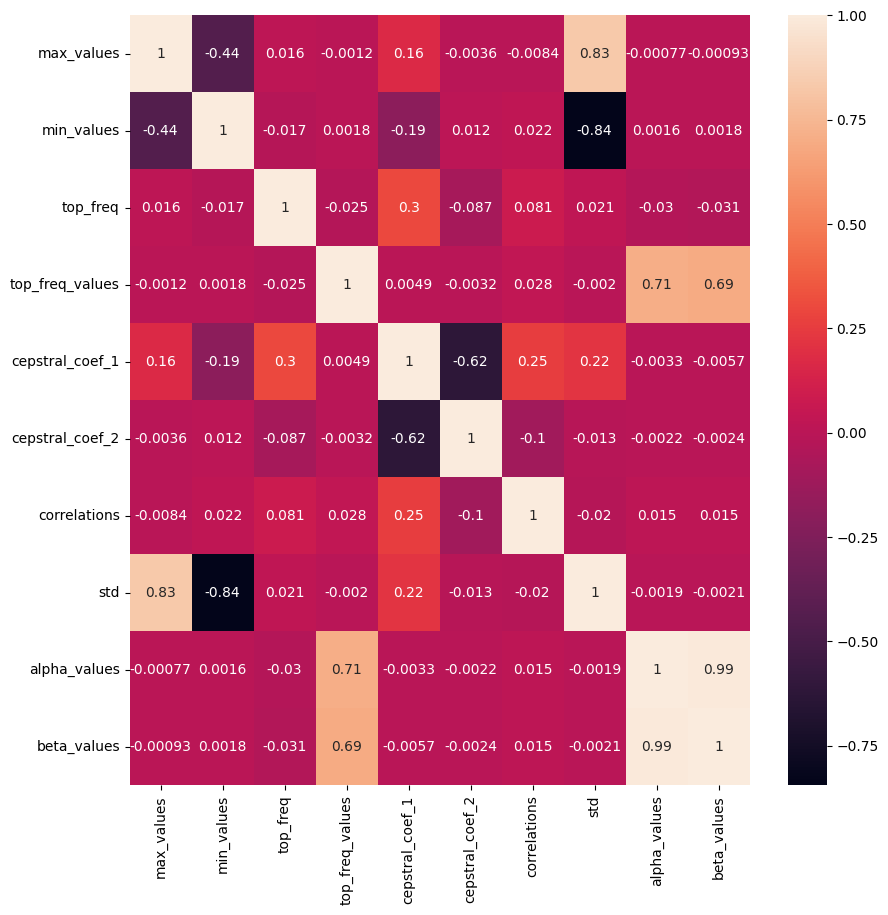

In [45]:
# Study the correlation between features

features = np.array([max_values, min_values, top_freq, top_freq_values, cepstral_coef_1, cepstral_coef_2, correlations, std, alpha_values, beta_values])

correlation_matrix = np.corrcoef(features)
print(correlation_matrix.shape)

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, xticklabels=["max_values", "min_values", "top_freq", "top_freq_values", "cepstral_coef_1", "cepstral_coef_2", "correlations", "std", "alpha_values", "beta_values"], yticklabels=["max_values", "min_values", "top_freq", "top_freq_values", "cepstral_coef_1", "cepstral_coef_2", "correlations", "std", "alpha_values", "beta_values"])
plt.show()

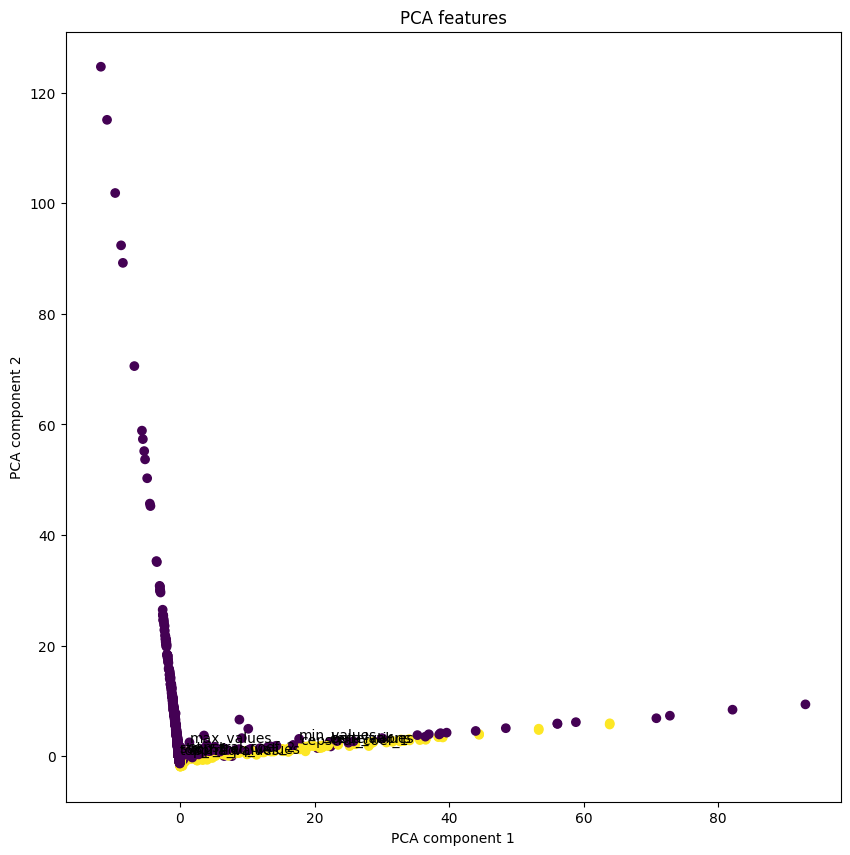

In [47]:
# Compute PCA

from sklearn.decomposition import PCA

# Normalize the features
features_normalized = (features - np.mean(features, axis=1, keepdims=True)) / np.std(features, axis=1, keepdims=True)

# Compute PCA
pca = PCA(n_components=2)
pca.fit(features_normalized.T)
pca_features = pca.transform(features_normalized.T)

# Plot the PCA features
plt.figure(figsize=(10, 10))
# color by target
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=targets_flatten)

for i, feature_name in enumerate(["max_values", "min_values", "top_freq", "top_freq_values", "cepstral_coef_1", "cepstral_coef_2", "correlations", "std", "alpha_values", "beta_values"]):
    plt.text(pca_features[i, 0], pca_features[i, 1], feature_name)

plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("PCA features")
plt.show()

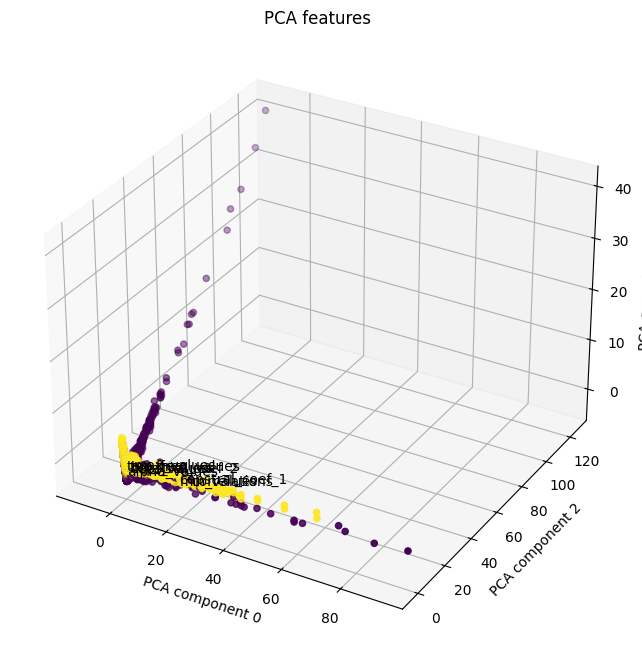

In [48]:
# PCA with 3 components
pca = PCA(n_components=3)
pca.fit(features_normalized.T)
pca_features = pca.transform(features_normalized.T)

# Plot the PCA features
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# color by target
ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], c=targets_flatten)

# Plot features as arrows
for i, feature_name in enumerate(["max_values", "min_values", "top_freq", "top_freq_values", "cepstral_coef_1", "cepstral_coef_2", "correlations", "alpha_values", "beta_values"]):
    ax.text(pca_features[i, 0], pca_features[i, 1], pca_features[i, 2], feature_name)

ax.set_ylabel("PCA component 2")
ax.set_xlabel("PCA component 0")
ax.set_zlabel("PCA component 1")
plt.title("PCA features")
plt.show()

